In [30]:
import os
import sys
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_squared_error

from data_loader import *

## Settings

In [31]:
num_train = 60
num_test = 10
num_total = num_train + num_test

ticker = "AAL"

window_size = 10
kernel_size = 5


## Data

In [32]:
X1, y1 = load_stock("AMZN")
X2, y2 = load_stock("TSLA")
X3, y3 = load_stock("AAPL")
X100, y100 = load_stock("QQQ")
X101, y101 = load_stock("SPY")

X = np.stack([X1, X2, X3, X100, X101])
X = X.reshape((X.shape[0] * X.shape[1], X.shape[-1]))
y = np.stack([y1, y2, y3])


X_train, y_train = setup_cov_tensors(X[:, -num_total: -num_test], y[:, -num_total: -num_test], window_size)
X_test, y_test = setup_cov_tensors(X[:, -num_test-window_size:], y[:, -num_test-window_size:], window_size)


In [33]:
print("Input", X.shape)
print("Out", y.shape)

Input (15, 2515)
Out (3, 2515)


## Model

In [51]:
# Define the 1D convolutional model
class StockReturnPredictor(nn.Module):
    def __init__(self, kernel_size, sequence_length):
        super(StockReturnPredictor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=15, out_channels=10, kernel_size=kernel_size)
        self.conv2 = nn.Conv1d(in_channels=10, out_channels=5, kernel_size=kernel_size)
        num_conv_layers = 2
        self.fc1 = nn.Linear(5 * (sequence_length - num_conv_layers * kernel_size + num_conv_layers * 1), 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc1(x)
        return x


## Train

In [52]:
# Instantiate the model, define loss and optimizer
model = StockReturnPredictor(kernel_size, window_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# Training loop
epochs = 4000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Add batch dimension and channel dimension (batch_size, channels, sequence_length)
    inputs_batch = X_train
    
    outputs = model(inputs_batch)

    loss = criterion(outputs, y_train.transpose(0, 1))
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

print("Training finished.")

Epoch [500/4000], Loss: 0.0001
Epoch [1000/4000], Loss: 0.0000
Epoch [1500/4000], Loss: 0.0000
Epoch [2000/4000], Loss: 0.0000
Epoch [2500/4000], Loss: 0.0000
Epoch [3000/4000], Loss: 0.0000
Epoch [3500/4000], Loss: 0.0000
Epoch [4000/4000], Loss: 0.0000
Training finished.


## Test

In [53]:
model.eval()

with torch.no_grad():
    test_outputs = model(X_test).squeeze()
    test_loss = mean_squared_error(y_test.transpose(0, 1).numpy(), test_outputs.numpy())
    print(f'Test Loss (MSE): {test_loss:.4f}')

Test Loss (MSE): 0.0007


## Plot

exp 0.0055886301806592955 real 0.004069857547237565
Accuracy 0.7


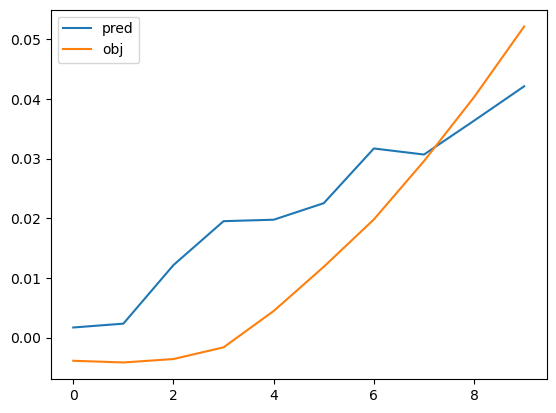

In [57]:
stock_id = 2
pred = np.array(test_outputs[:, stock_id])
#pred[np.abs(pred) < 0.01] = 0
obj = np.array(y_test[stock_id])

exp = np.sqrt(np.dot(pred, pred) / len(pred))
real = (np.dot(pred, obj) / len(pred)) / exp

print("exp", exp, "real", real)
print("Accuracy", np.sum((pred * obj) > 0)/np.sum(pred != 0))

obj_sort = np.argsort(obj)
plt.plot(np.cumsum(pred[obj_sort]), label="pred")
plt.plot(np.cumsum(obj[obj_sort]), label="obj")

plt.legend()

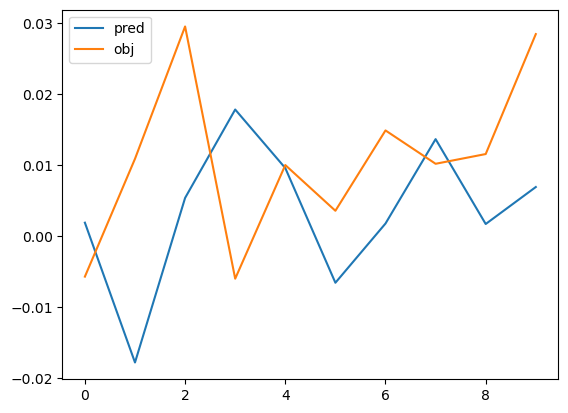

In [55]:
plt.plot((pred), label="pred")
plt.plot((obj), label="obj")

plt.legend()